<a href="https://colab.research.google.com/github/ddcreating/RL_code/blob/main/lab3_TD_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Temporal Difference Learning

In this lab, we will practice TD Learning methods, including SARSA and Q-Learning. Both are tabular methods that work on finite MDP.

We will solve the cliff problem: https://gymnasium.farama.org/environments/toy_text/cliff_walking/#is_slippy


The following code runs in colab, if you want to see the animation, you have to run it using python locally on your computer and replacing render_mode="ansi" for render_mode="human".

Thef follwing code runs the cliff problem using a random policy.

In [ ]:
import gymnasium as gym

# Create the environment
env = gym.make("CliffWalking-v1", render_mode="ansi")

n_episodes = 5      # number of episodes to run
max_steps = 100     # safety cap

for episode in range(n_episodes):
    state, info = env.reset()
    done = False
    total_reward = 0

    for step in range(max_steps):
        # Random policy: sample an action uniformly
        action = env.action_space.sample()

        next_state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        state = next_state

        if terminated or truncated:
            break

    print(f"Episode {episode+1}: total reward = {total_reward}")

env.close()

Episode 1: total reward = -1486
Episode 2: total reward = -1486
Episode 3: total reward = -793
Episode 4: total reward = -496
Episode 5: total reward = -496


## Exercise 1: SARSA
Implement SARSA to solve the cliff problem above. Recommendations:



1. Define your Q table, as a matrix of [number of states] x [number of actions]
2. Greedy policy: Write a function that receives a state, the Q table, and returns the best action (the one with the maximum Q value).
3. $\epsilon$-greedy: Wreite a function that chooses the greedy policy with $\epsilon$ probality, and chooses a random actions with 1-$\epsilon$ probability.
4. Implement the SARSA algorithm based on the pseudo-code



Training done. Avg return (last 100): -18.19


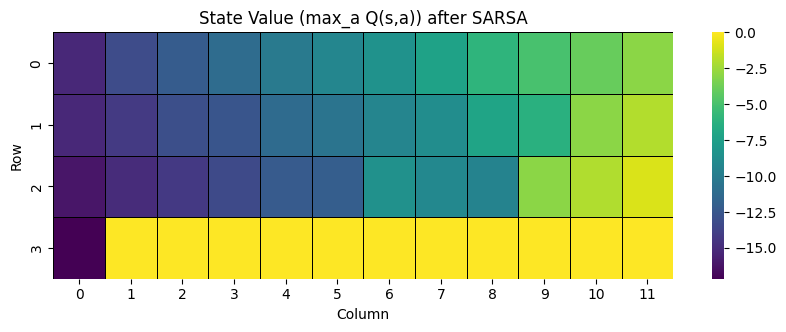

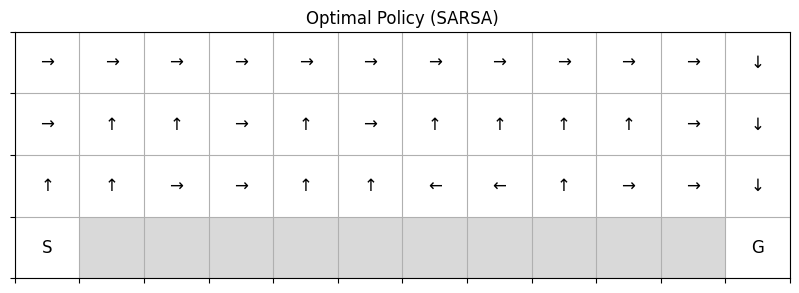

Greedy policy average return over 50 episodes: -17.00


In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------ 1) 环境 ------------
env = gym.make("CliffWalking-v1")   # render_mode 可用 'ansi' 本地看动画
nS = env.observation_space.n        # 4*12 = 48
nA = env.action_space.n             # 4

# ------------ 2) Q 表 ------------
Q = np.zeros((nS, nA), dtype=np.float32)

# ------------ 3) 策略函数 ------------
# greedy：返回 Q 最大的动作（打破并列：np.argmax）
def greedy_action(Q, s):
    return int(np.argmax(Q[s]))

# epsilon-greedy：以 (1-ε) 概率选 greedy，以 ε 概率随机
rng = np.random.default_rng(seed=0)
def epsilon_greedy_action(Q, s, epsilon):
    if rng.random() < epsilon:
        return int(rng.integers(nA))
    else:
        return greedy_action(Q, s)

# ------------ 4) SARSA 训练 ------------
alpha = 0.5          # 学习率
gamma = 1.0          # 折扣因子（CliffWalking 通常用 1.0）
epsilon = 0.1        # 初始 ε
eps_min = 0.01       # 最小 ε
eps_decay = 0.995    # 每个 episode 衰减（可根据需要调整）
n_episodes = 800     # 训练回合数
max_steps = 200      # 防无限循环

returns = []

for ep in range(n_episodes):
    s, _ = env.reset()
    a = epsilon_greedy_action(Q, s, epsilon)
    total = 0.0

    for t in range(max_steps):
        s_next, r, terminated, truncated, _ = env.step(a)
        total += r

        # 下一个动作（on-policy）
        if not (terminated or truncated):
            a_next = epsilon_greedy_action(Q, s_next, epsilon)
        else:
            a_next = 0  # 占位，不会用到

        # SARSA 更新
        target = r + (0 if terminated or truncated else gamma * Q[s_next, a_next])
        Q[s, a] += alpha * (target - Q[s, a])

        s, a = s_next, a_next

        if terminated or truncated:
            break

    returns.append(total)
    epsilon = max(eps_min, epsilon * eps_decay)

print(f"Training done. Avg return (last 100): {np.mean(returns[-100:]):.2f}")

# ------------ 5) 训练后：提取策略 & 可视化 ------------
# 将 0..47 映射为 (row, col)，环境是 4x12：row=0 顶部，row=3 底部
nrow, ncol = 4, 12

# 贪婪策略（训练好的 Q）
pi = np.argmax(Q, axis=1).reshape(nrow, ncol)

# 值函数（对每个状态取 max_a Q）
V = np.max(Q, axis=1).reshape(nrow, ncol)

# 画值函数热力图（顶行在上）
plt.figure(figsize=(10, 3.2))
sns.heatmap(V, annot=False, cmap="viridis", cbar=True,
            linewidths=.6, linecolor="k", square=False)
plt.title("State Value (max_a Q(s,a)) after SARSA")
plt.xlabel("Column")
plt.ylabel("Row")
plt.show()

# 画策略箭头（和 slide 风格一致）
arrow = {0:'↑', 1:'→', 2:'↓', 3:'←'}  # 动作到箭头
fig, ax = plt.subplots(figsize=(10, 3.2))
ax.set_xlim(0, ncol); ax.set_ylim(0, nrow)
ax.set_xticks(np.arange(ncol+1)); ax.set_yticks(np.arange(nrow+1))
ax.grid(True, which='both')

# 把 cliff 区域涂灰（底行的 1..10 列是 cliff；0 是 S，11 是 G）
for c in range(1, ncol-1):
    rect = plt.Rectangle((c, nrow-1), 1, 1, facecolor='0.85')
    ax.add_patch(rect)

# 在每个格子中心写箭头；S/G 写成 S/G
for r in range(nrow):
    for c in range(ncol):
        s = r * ncol + c
        if r == nrow-1 and c == 0:
            txt = 'S'
        elif r == nrow-1 and c == ncol-1:
            txt = 'G'
        elif r == nrow-1 and 1 <= c <= ncol-2:
            txt = ''  # 悬崖格不画箭头
        else:
            txt = arrow[int(pi[r, c])]
        ax.text(c + 0.5, r + 0.5, txt, ha='center', va='center', fontsize=12)

ax.set_xticklabels([]); ax.set_yticklabels([])
plt.title("Optimal Policy (SARSA)")
plt.gca().invert_yaxis()   # 视觉上把 row=0 放到上方
plt.show()

# ------------ 6)（可选）评估贪婪策略 ------------
def evaluate_policy(Q, episodes=50, max_steps=200):
    tot = 0.0
    for _ in range(episodes):
        s, _ = env.reset()
        ep_ret = 0.0
        for _ in range(max_steps):
            a = greedy_action(Q, s)
            s, r, term, trunc, _ = env.step(a)
            ep_ret += r
            if term or trunc:
                break
        tot += ep_ret
    return tot / episodes

avg_eval = evaluate_policy(Q)
print(f"Greedy policy average return over 50 episodes: {avg_eval:.2f}")


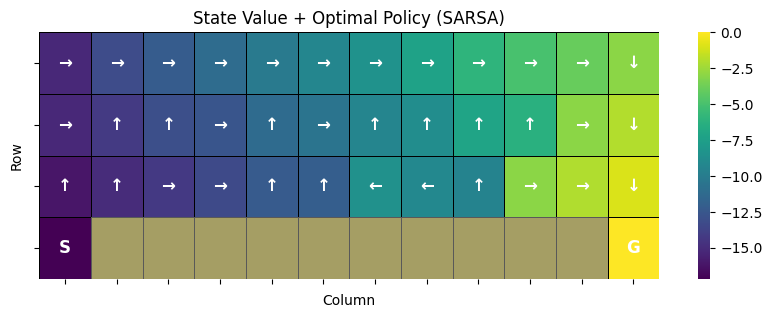

In [7]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ========== 1) 环境 ==========
env = gym.make("CliffWalking-v1")   # 4x12 网格
nS = env.observation_space.n        # 48
nA = env.action_space.n             # 4

# ========== 2) Q 表 ==========
Q = np.zeros((nS, nA), dtype=np.float32)

# ========== 3) 策略函数 ==========
def greedy_action(Q, s):
    return int(np.argmax(Q[s]))

rng = np.random.default_rng(seed=0)
def epsilon_greedy_action(Q, s, epsilon):
    if rng.random() < epsilon:
        return int(rng.integers(nA))
    else:
        return greedy_action(Q, s)

# ========== 4) SARSA 训练 ==========
alpha   = 0.5      # 学习率
gamma   = 1.0      # 折扣
epsilon = 0.1      # 初始 ε
eps_min = 0.01
eps_decay = 0.995
n_episodes = 800
max_steps  = 200

returns = []
for ep in range(n_episodes):
    s, _ = env.reset()
    a = epsilon_greedy_action(Q, s, epsilon)
    total = 0.0

    for t in range(max_steps):
        s_next, r, terminated, truncated, _ = env.step(a)
        total += r

        if not (terminated or truncated):
            a_next = epsilon_greedy_action(Q, s_next, epsilon)
        else:
            a_next = 0  # 占位

        # SARSA 更新
        target = r + (0 if terminated or truncated else gamma * Q[s_next, a_next])
        Q[s, a] += alpha * (target - Q[s, a])

        s, a = s_next, a_next
        if terminated or truncated:
            break

    returns.append(total)
    epsilon = max(eps_min, epsilon * eps_decay)

print(f"[Train] Avg return (last 100): {np.mean(returns[-100:]):.2f}")

# ========== 5) 单图可视化：值函数 + 箭头 + 悬崖(底行) ==========
nrow, ncol = 4, 12
pi = np.argmax(Q, axis=1).reshape(nrow, ncol)   # 贪婪策略
V  = np.max(Q, axis=1).reshape(nrow, ncol)      # 值函数
arrow = {0:'↑', 1:'→', 2:'

In [ ]:

import gymnasium as gym
import numpy as np

# Create the environment
env = gym.make("CliffWalking-v1", render_mode="ansi")

n_episodes = 1000      # number of episodes to run
max_steps = 100     # safety cap

# Q-learning parameters
learning_rate = 0.1
discount_factor = 0.99
n_actions = env.action_space.n
n_states = env.observation_space.n
Q = np.zeros((n_states, n_actions))



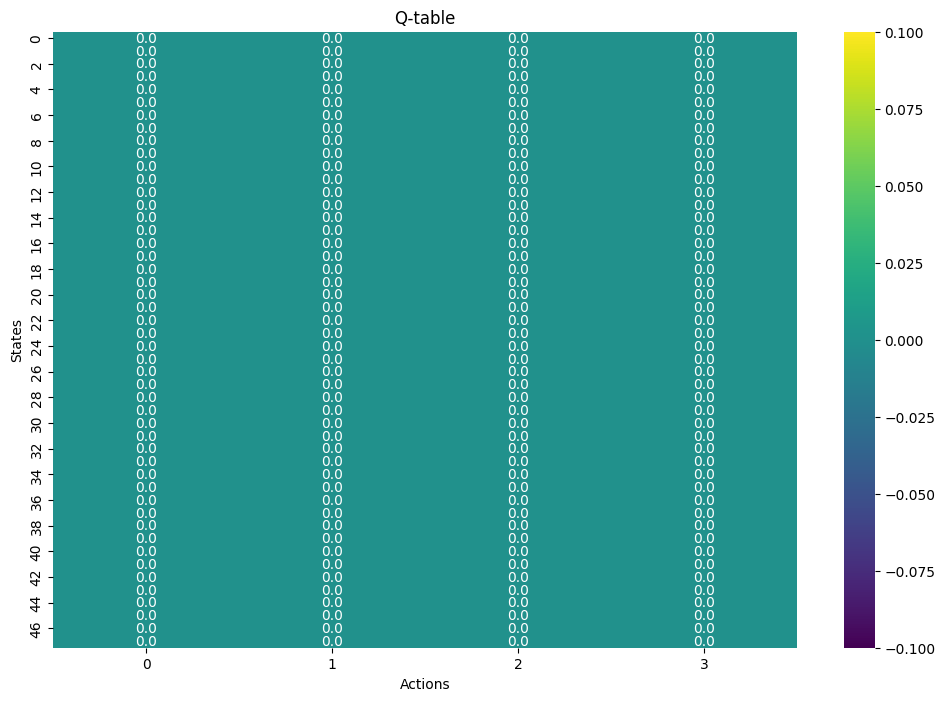

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_Q(Q):
  plt.figure(figsize=(12, 8))
  sns.heatmap(Q, annot=True, fmt=".1f", cmap="viridis")
  plt.xlabel("Actions")
  plt.ylabel("States")
  plt.title("Q-table")
  plt.show()

plot_Q(Q)

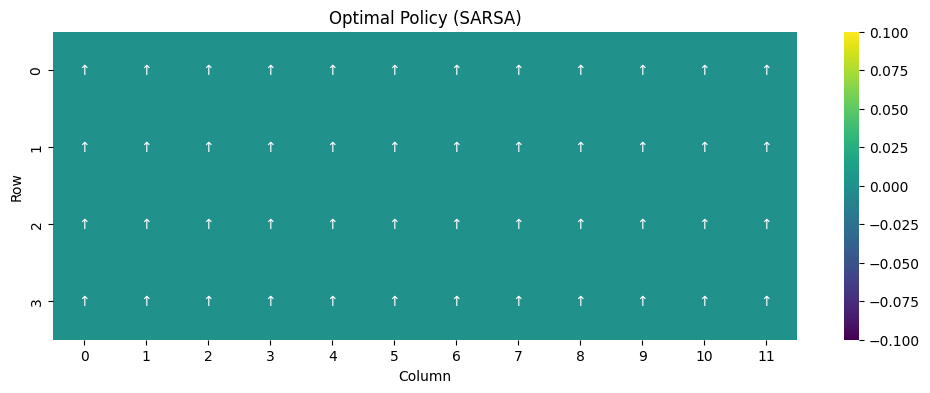

In [ ]:
def plot_policy(Q, title="SARSA"):
  # Reshape Q table to a 4x12 grid
  Q_grid = Q.reshape((4, 12, n_actions))

  # Get the optimal action for each state and its corresponding Q-value
  optimal_action = np.argmax(Q_grid, axis=2)
  optimal_policy_Q = np.max(Q_grid, axis=2)


  # Define arrow mapping based on action space (0: up, 1: right, 2: down, 3: left)
  action_arrows = {0: "↑", 1: "→", 2: "↓", 3: "←"}
  optimal_policy_arrows = np.vectorize(action_arrows.get)(optimal_action)


  plt.figure(figsize=(12, 4))
  sns.heatmap(optimal_policy_Q, annot=optimal_policy_arrows, fmt="", cmap="viridis", cbar=True) # Add color bar back
  plt.xlabel("Column")
  plt.ylabel("Row")
  plt.title("Optimal Policy (SARSA)")
  plt.show()
plot_policy(Q)

## Exercise 2.1: Q: Learning
Implement Q-learning method to solve the cliff problem

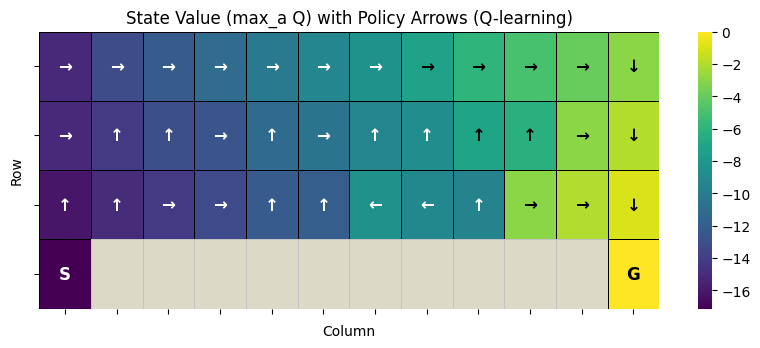

In [3]:
# ----- 单图：在热力图上叠加箭头 -----
nrow, ncol = 4, 12
V = np.max(Q, axis=1).reshape(nrow, ncol)
PI = np.argmax(Q, axis=1).reshape(nrow, ncol)
arrow = {0:'↑', 1:'→', 2:'↓', 3:'←'}

fig, ax = plt.subplots(figsize=(10, 3.6))

# 1) 画值函数热力图（seaborn 默认把 row=0 显示在最上面）
hm = sns.heatmap(
    V, ax=ax, cmap="viridis", cbar=True,
    linewidths=.6, linecolor="k", annot=False, square=False
)
ax.set_title("State Value (max_a Q) with Policy Arrows (Q-learning)")
ax.set_xlabel("Column"); ax.set_ylabel("Row")

# 2) 先把 cliff 区域叠灰（底行 1..10 列）
for c in range(1, ncol-1):
    ax.add_patch(plt.Rectangle((c, nrow-1), 1, 1, facecolor='0.85', alpha=0.9, ec='none'))

# 3) 在每个格子中心写箭头 / S / G
V_mid = np.nanmean(V)  # 用于决定箭头颜色对比
for r in range(nrow):
    for c in range(ncol):
        # 选择文字内容
        if r == nrow-1 and c == 0:
            txt = 'S'
        elif r == nrow-1 and c == ncol-1:
            txt = 'G'
        elif r == nrow-1 and 1 <= c <= ncol-2:
            txt = ''   # 悬崖格不写箭头
        else:
            txt = arrow[int(PI[r, c])]

        if txt:
            # 根据背景深浅换文字颜色，保证可读性
            clr = 'w' if V[r, c] <= V_mid else 'k'
            ax.text(c + 0.5, r + 0.5, txt,
                    ha='center', va='center',
                    fontsize=12, fontweight='bold', color=clr)

# 4) 美化坐标
ax.set_xticklabels([]); ax.set_yticklabels([])
plt.show()


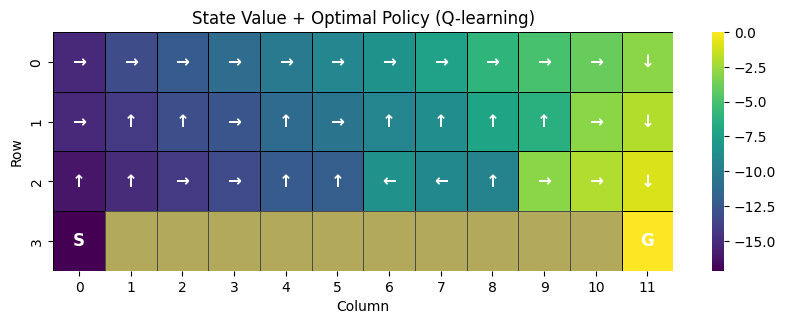

In [6]:
# 映射为 4x12
nrow, ncol = 4, 12
V = np.max(Q, axis=1).reshape(nrow, ncol)
PI = np.argmax(Q, axis=1).reshape(nrow, ncol)

# 箭头字典
arrow = {0:'↑', 1:'→', 2:'↓', 3:'←'}

plt.figure(figsize=(10, 3.1))
ax = sns.heatmap(V, cmap="viridis", cbar=True, linewidths=.6, linecolor="k")

# 悬崖在「最底行」= row = nrow-1 (即 3)
for c in range(1, ncol-1):
    ax.add_patch(plt.Rectangle((c, nrow-1), 1, 1, facecolor='0.5', alpha=0.6))

# 在热力图上叠加箭头 / S / G
for r in range(nrow):
    for c in range(ncol):
        if r == nrow-1 and c == 0:
            txt = 'S'
        elif r == nrow-1 and c == ncol-1:
            txt = 'G'
        elif r == nrow-1 and 1 <= c <= ncol-2:
            txt = ''   # 悬崖格不画箭头
        else:
            txt = arrow[int(PI[r, c])]
        ax.text(c+0.5, r+0.5, txt, ha='center', va='center',
                fontsize=12, color='w', weight='bold')

plt.title("State Value + Optimal Policy (Q-learning)")
plt.xlabel("Column"); plt.ylabel("Row")

# 这一行要删掉，否则显示会翻转
# plt.gca().invert_yaxis()

plt.show()


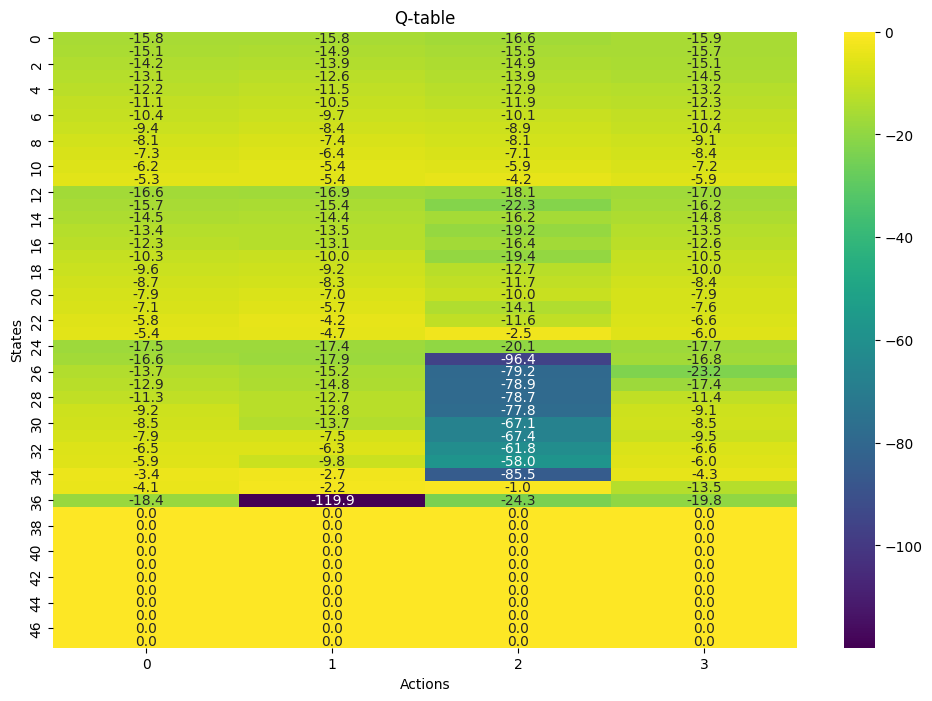

In [ ]:
plot_Q(Q)

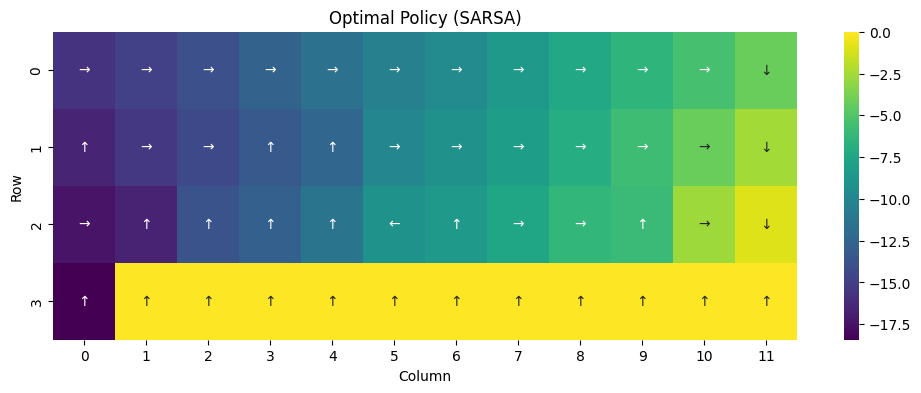

In [ ]:
plot_policy(Q, "Q-Learning")

## Exercise 2.2: SARSA vs Q-learning
 1. Compare the results betwen SARSA and Q-Learning (plot a graph of the sum of rewards duing each episode for each algorithm).
 2. Include the is_slippery=True parameter. Compare again, which one is better?


# Exercise 3 (graduate students): 8x8 grid problem
Solve the 8x8 grid problem from the previous lab. You can use SARSA or Q-learning. How many episodes does it need to learn the optimal policy?
